## Import Libraries

In [1]:
from matplotlib import pyplot as plt
import torch
import numpy as np
import random
from Util.Transformers import Conv2dFilter
from Util.Pooling import MeanPooling
from matplotlib.gridspec import GridSpec
from Coding.Encoders import TTFSCoding, PoissonCoding
from Util.Filters import DoGFilter, GaborFilter

/Users/mohazamani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Set Seeds

In [2]:
seed = 2020
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Visualize Matrix

In [3]:
import numpy as np


def visualize(data: list[list], x_scale=1.2, y_sale=2, font=9, figsize=(6, 6)) -> None:
    # Convert the data to a NumPy array for easier manipulation
    data_array = np.array(data)

    # Create a figure and a single subplot
    fig, ax = plt.subplots(figsize=figsize)  # Width and height in inches

    # Hide axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create the table
    table = ax.table(cellText=data_array, cellLoc='center', loc='center')

    # Scale the table
    table.auto_set_font_size(False)
    table.set_fontsize(font)
    table.scale(x_scale, y_sale)

    # Display the table
    plt.show()

## TTFS

In [4]:
class BaseCodingChecker:
    def load_image(self, image: list[np.array]) -> None:
        self.org_im = image
        self.com_im = MeanPooling(size=(5, 5))(self.org_im)

In [5]:
class TTFS(BaseCodingChecker):

    def normalize(self, image):
        min_val = image.min()
        max_val = image.max()

        normalized_image = 256 * (image - min_val) / (max_val - min_val)

        return np.clip(normalized_image, 0, 256)

    def encode(self, time: int = 250):
        self.time = time
        ttfs = TTFSCoding(time=time)

        self.org_im = self.normalize(self.org_im)
        self.com_im = self.normalize(self.com_im)

        self.org_im_code = ttfs(data=torch.Tensor(
            self.org_im.flatten() / 256))
        self.com_im_code = ttfs(data=torch.Tensor(
            self.com_im.flatten() / 256))

    def prepare_data_for_plot(self):
        self.org_im_code = torch.nonzero(self.org_im_code == 1)
        self.com_im_code = torch.nonzero(self.com_im_code == 1)

        self.com_im_data, self.org_im_data = {}, {}

        for i in range(self.time):
            self.org_im_data[i] = (self.org_im_code[self.org_im_code[:, 1]
                                                    == i][:, 0]).tolist()
            self.com_im_data[i] = (self.com_im_code[self.com_im_code[:, 1]
                                                    == i][:, 0]).tolist()

        org_x, org_y = list(self.org_im_data.keys()), list(
            self.org_im_data.values())
        com_x, com_y = list(self.com_im_data.keys()), list(
            self.com_im_data.values())

        self.x_org_flattened, self.y_org_flattened = [], []
        self.x_com_flattened, self.y_com_flattened = [], []

        for i, y_values in enumerate(org_y):
            self.x_org_flattened.extend([org_x[i]] * len(y_values))
            self.y_org_flattened.extend(y_values)

        for i, y_values in enumerate(com_y):
            self.x_com_flattened.extend([com_x[i]] * len(y_values))
            self.y_com_flattened.extend(y_values)

    def raster_plot(self):
        plt.rcParams.update({'font.size': 6})
        _, ax = plt.subplots(figsize=(6, 6))
        gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[
                      1, 1], wspace=0.3, hspace=0.3)

        ax1 = plt.subplot(gs[0])
        ax1.imshow(self.org_im, cmap='gray')
        ax1.axis('off')

        ax2 = plt.subplot(gs[1])
        ax2.scatter(self.x_org_flattened, self.y_org_flattened, s=3, c='black', label='ex',
                    alpha=0.3, edgecolors='none', marker='.')

        ax3 = plt.subplot(gs[2])
        ax3.imshow(self.com_im, cmap='gray')
        ax3.axis('off')

        ax4 = plt.subplot(gs[3])
        ax4.scatter(self.x_com_flattened, self.y_com_flattened, s=4, c='black', label='ex',
                    alpha=0.3, edgecolors='none', marker='.')

        for ax in [ax2, ax4]:
            ax.set_xlabel('Time', fontsize=8)
            ax.set_ylabel('Neuron Id', fontsize=8)
            ax.set_title('Scatter Plot', pad=10, fontsize=8)
        ax1.set_title('Original Image', pad=10, fontsize=8)
        ax3.set_title('Compressed Image', pad=10, fontsize=8)

        plt.show()

## PIOSSON

In [6]:
class PCoding(BaseCodingChecker):
    def normalize(self, image):
        min_val = image.min()
        max_val = image.max()

        normalized_image = 256 * (image - min_val) / (max_val - min_val)

        return np.clip(normalized_image, 0, 256)

    def encode(self, time: int = 250, lambda_param=0.09):
        pc = PoissonCoding(time_window=time, ratio=0.01)

        self.org_im = self.normalize(self.org_im)
        self.com_im = self.normalize(self.com_im)

        self.org_im_code = pc(torch.Tensor(
            self.org_im.flatten()) / self.org_im.max())

        self.com_im_code = pc(torch.Tensor(
            self.com_im.flatten()) / self.com_im.max())

    def prepare_data_for_plot(self):
        self.org_im_data = torch.nonzero(self.org_im_code == True)
        self.com_im_data = torch.nonzero(self.com_im_code == True)

    def raster_plot(self):
        plt.rcParams.update({'font.size': 6})
        _, ax = plt.subplots(figsize=(6, 6))
        gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[
                      1, 1], wspace=0.3, hspace=0.3)

        ax1 = plt.subplot(gs[0])
        ax1.imshow(self.org_im, cmap='gray')
        ax1.axis('off')

        ax2 = plt.subplot(gs[1])
        ax2.scatter(self.org_im_data[:, 1], self.org_im_data[:, 0], s=1, c='black', label='ex',
                    alpha=0.3, edgecolors='none', marker='.')

        ax3 = plt.subplot(gs[2])
        ax3.imshow(self.com_im, cmap='gray')
        ax3.axis('off')

        ax4 = plt.subplot(gs[3])
        ax4.scatter(self.com_im_data[:, 1], self.com_im_data[:, 0], s=5, c='black', label='ex',
                    alpha=0.3, edgecolors='none', marker='.')

        for ax in [ax2, ax4]:
            ax.set_xlabel('Time', fontsize=8)
            ax.set_ylabel('Neuron Id', fontsize=8)
            ax.set_title('Scatter Plot', pad=10, fontsize=8)
        ax1.set_title('Original Image', pad=10, fontsize=8)
        ax3.set_title('Compressed Image', pad=10, fontsize=8)

        plt.show()

In [40]:
class Filter:
    def __init__(self, dir: str, filter: DoGFilter or GaborFilter) -> None:
        self.im_dir = dir
        self.original_image = plt.imread(dir)
        self.filter_mat = filter.unsqueeze(0).unsqueeze(0)

    def apply_filter(self):
        dig_filter_on_center = Conv2dFilter(filters=self.filter_mat)

        dig_filter_off_center = Conv2dFilter(filters=-1 * self.filter_mat)

        self.filtered_image_on_center = dig_filter_on_center(torch.from_numpy(
            self.original_image).unsqueeze(0).to(torch.float32)).squeeze(0)

        self.filtered_image_off_center = dig_filter_off_center(torch.from_numpy(
            self.original_image).unsqueeze(0).to(torch.float32)).squeeze(0)

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(self.original_image, cmap='gray')
        axes[0].axis('off')
        axes[0].set_title('Original Image', pad=10)
        axes[1].imshow(self.filtered_image_on_center, cmap='gray')
        axes[1].axis('off')
        axes[1].set_title('Convolved Using on-center kernel', pad=10)
        axes[2].imshow(self.filtered_image_off_center, cmap='gray')
        axes[2].axis('off')
        axes[2].set_title('Convolved using off-center kernel', pad=10)

        plt.show()

    def visualize_filter_mat(self, decimal_places: int = 3) -> None:
        formatted = self.filter_mat.squeeze(0).squeeze(0).clone().detach()
        for i in range(formatted.shape[0]):
            for j in range(formatted.shape[1]):
                formatted[i, j] = float(
                    f"{formatted[i, j]:.{decimal_places}f}")
        visualize(formatted, x_scale=1, y_sale=2.4, font=7, figsize=(5.5, 5.5))

    def visualize_filter_off_center(self) -> None:
        plt.figure(figsize=(2.5, 2.5))
        plt.axis('off')
        plt.imshow(self.filter_mat.squeeze(0).squeeze(0), cmap='gray')

    def visualize_filter_on_center(self) -> None:
        plt.figure(figsize=(2.5, 2.5))
        plt.axis('off')
        plt.imshow((-1 * self.filter_mat).squeeze(0).squeeze(0), cmap='gray')

    def TTFS_coding(self):
        ttfs = TTFS()
        ttfs.load_image(image=self.filtered_image_on_center)
        ttfs.encode()
        ttfs.prepare_data_for_plot()
        ttfs.raster_plot()

    def piosson_coding(self) -> None:
        pcode = PCoding()
        pcode.load_image(image=self.filtered_image_on_center)
        pcode.encode()
        pcode.prepare_data_for_plot()
        pcode.raster_plot()

    def exec(self):
        self.apply_filter()
        # self.visualize_filter_mat()
        self.visualize_filter_off_center()
        self.visualize_filter_on_center()
        self.TTFS_coding()
        self.piosson_coding()


class GFilter(Filter):
    def __init__(self, dir: str, filters: list[GaborFilter]) -> None:
        self.im_dir = dir
        self.original_image = plt.imread(dir)
        self.filter_mats = [filter.unsqueeze(
            0).unsqueeze(0) for filter in filters]

    def apply_filter(self):
        self.filtered_imgs = [self.original_image]
        for filter_mat in self.filter_mats:
            dig_filter = Conv2dFilter(filters=filter_mat)

            self.filtered_imgs.append(dig_filter(torch.from_numpy(
                self.original_image).unsqueeze(0).to(torch.float32)).squeeze(0))

        self.filtered_image_on_center = self.filtered_imgs[1]

        fig, axes = plt.subplots(1, len(self.filtered_imgs), figsize=(20, 5))
        for i, img in enumerate(self.filtered_imgs):
            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')

        axes[0].set_title("Original Image")
        # axes[1].set_title(r'$\sigma = 1$', fontdict={'size': 12})
        # axes[2].set_title(r'$\sigma = 1.5 $', fontdict={'size': 12})
        # axes[3].set_title(r'$\sigma = 2 $', fontdict={'size': 12})
        # axes[4].set_title(r'$\sigma = 2.5 $', fontdict={'size': 12})
        # axes[5].set_title(r'$\sigma = 3 $', fontdict={'size': 12})
        plt.show()

    def visualize_filters(self):
        fig, axes = plt.subplots(1, len(self.filter_mats), figsize=(15, 2.5))

        for i, filter in enumerate(self.filter_mats):
            axes[i].axis('off')
            axes[i].imshow((-1 * filter).squeeze(0).squeeze(0), cmap='gray')

        # axes[0].set_title(r'$\sigma = 1 $', fontdict={'size': 12})
        # axes[1].set_title(r'$\sigma = 1.5$', fontdict={'size': 12})
        # axes[2].set_title(r'$\sigma = 2 $', fontdict={'size': 12})
        # axes[3].set_title(r'$\sigma = 2.5 $', fontdict={'size': 12})
        # axes[4].set_title(r'$\sigma = 3 $', fontdict={'size': 12})

    def exec(self):
        self.apply_filter()
        # self.visualize_filter_mat()
        self.visualize_filters()
        # self.visualize_filter_on_center()
        self.TTFS_coding()
        self.piosson_coding()

### DoG Filter:

#### Sample:

/var/folders/hf/43w7b51j725973smp2rmsbkc0000gp/T/ipykernel_90131/1239544384.py:12: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  self.filtered_image_on_center = dig_filter_on_center(torch.from_numpy(


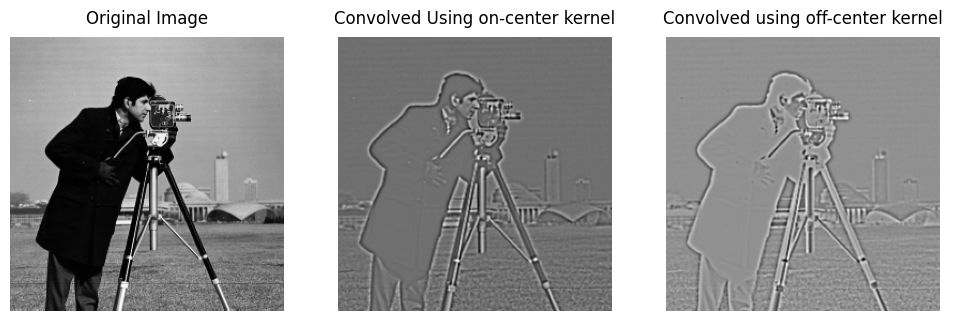

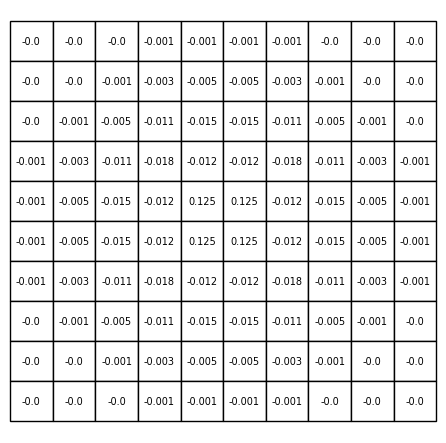

/var/folders/hf/43w7b51j725973smp2rmsbkc0000gp/T/ipykernel_90131/3678289709.py:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0])


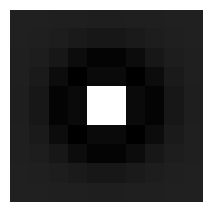

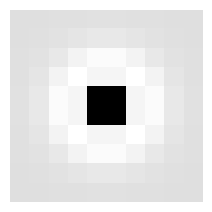

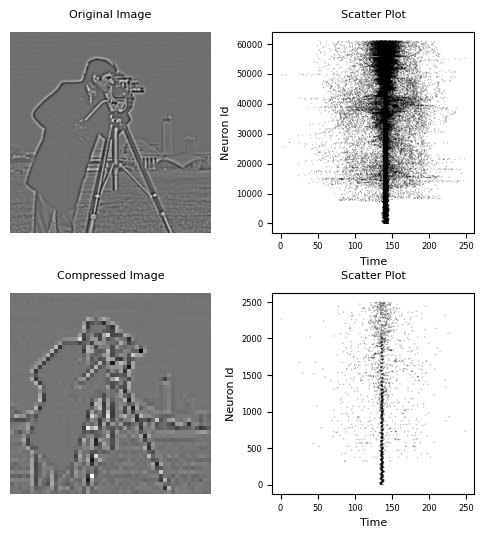

/var/folders/hf/43w7b51j725973smp2rmsbkc0000gp/T/ipykernel_90131/2433122957.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0])


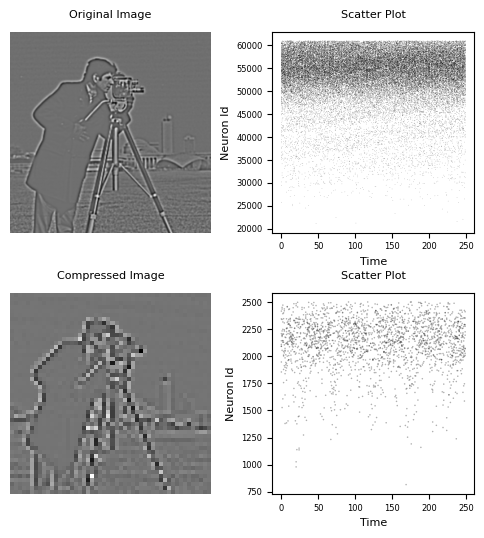

In [9]:
filter_one = Filter(dir='./data/camera.tif', filter=DoGFilter(10, 1, 1.5, one_sum=True,
                                                              zero_mean=True))

filter_one.exec()

#### Check Parameters:

size=  10  sigma_1=  1  sigma_2=  1.5


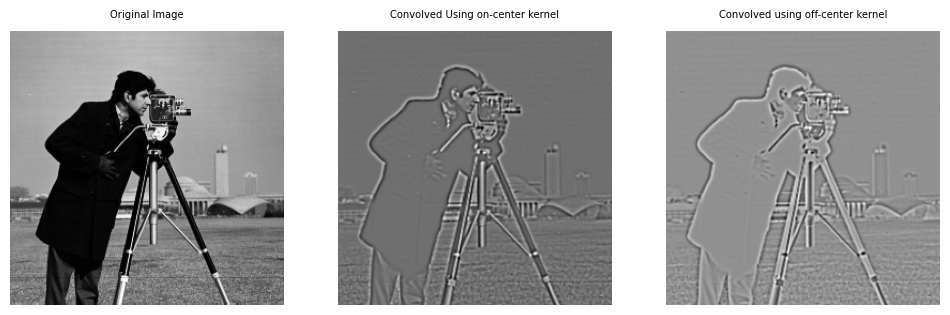

size=  10  sigma_1=  1  sigma_2=  20


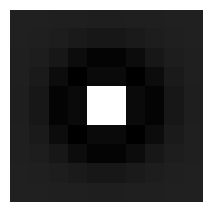

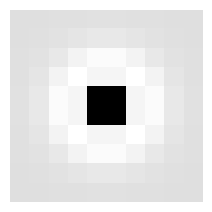

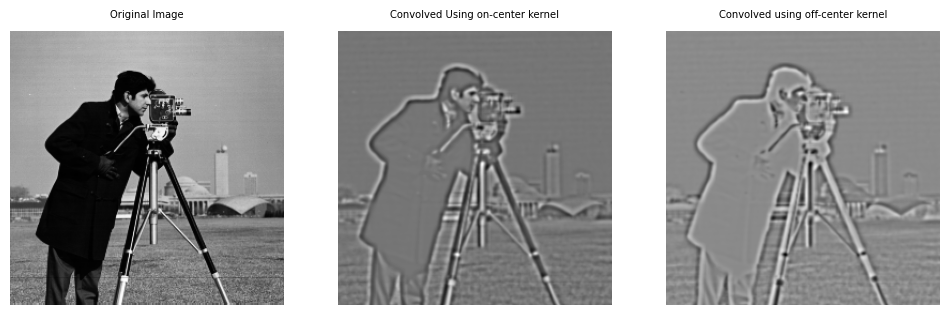

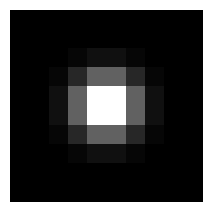

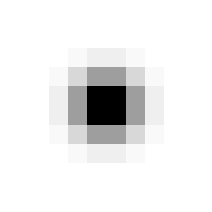

In [22]:
# 1. size
# 2. sigma_1
# 3. sigma_3

sigma_1s = [1]
sigma_2s = [1.5, 20]

for sigma_1 in sigma_1s:
    for sigma_2 in sigma_2s:
        if (sigma_1 != sigma_2):
            filter_one = Filter(dir='./data/camera.tif', filter=DoGFilter(10, sigma_1, sigma_2, one_sum=True,
                                                                          zero_mean=True))

            print("size= ", 10, " sigma_1= ", sigma_1, " sigma_2= ", sigma_2)
            filter_one.apply_filter()
            filter_one.visualize_filter_off_center()
            filter_one.visualize_filter_on_center()
            del filter_one

### Gabor Filter

#### Sample

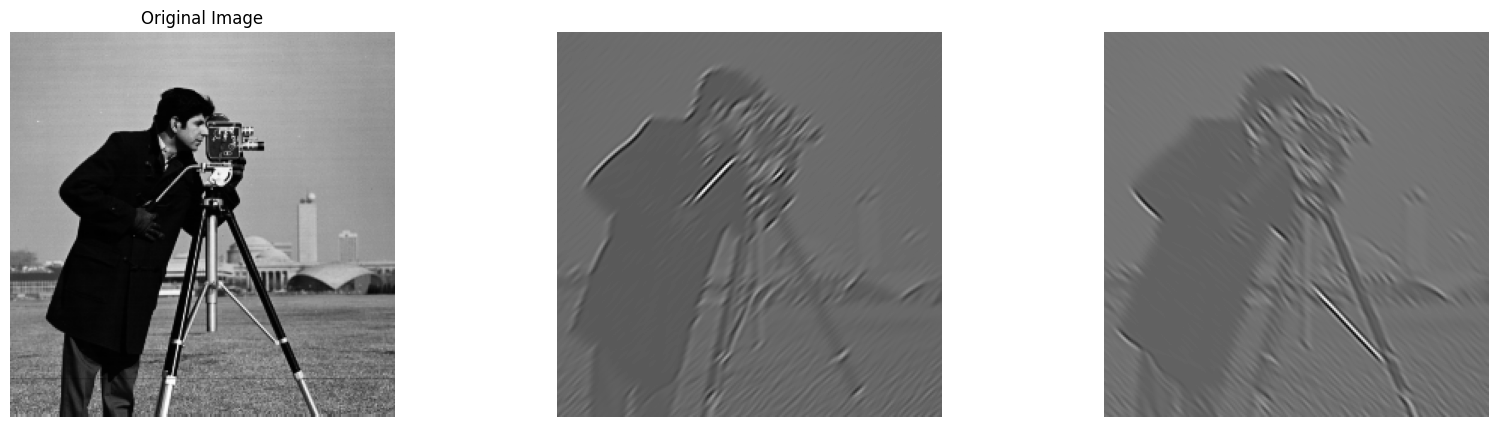

/var/folders/hf/43w7b51j725973smp2rmsbkc0000gp/T/ipykernel_17839/3678289709.py:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0])


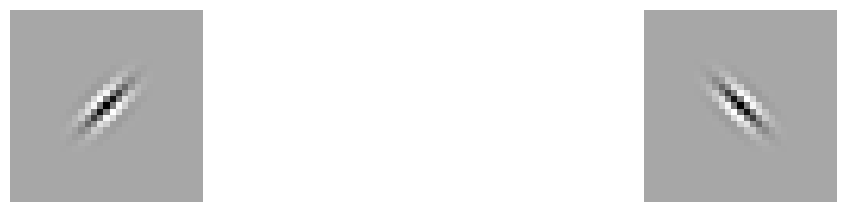

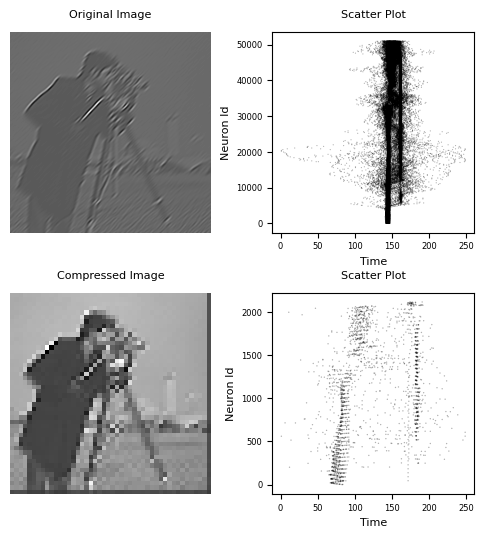

/var/folders/hf/43w7b51j725973smp2rmsbkc0000gp/T/ipykernel_17839/2433122957.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0])


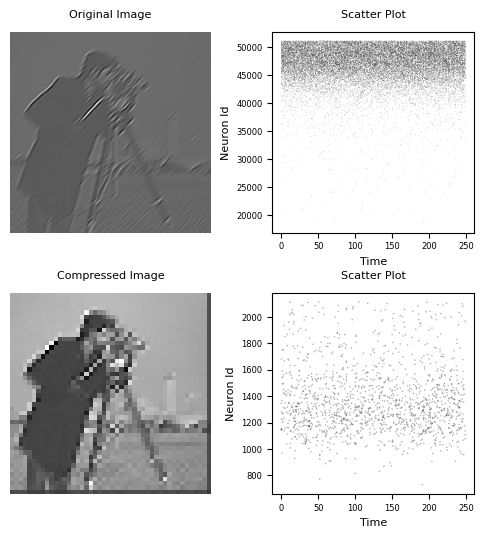

In [41]:
filter_two = GFilter(dir='./data/camera.tif',
                     filters=[GaborFilter(31, 3.5, np.pi / 4, 1.5, 0.5), GaborFilter(31, 3.5, (3 * np.pi) / 4, 1.5, 0.5)])

filter_two.exec()

#### Paramter Analysis

#### $\Theta$

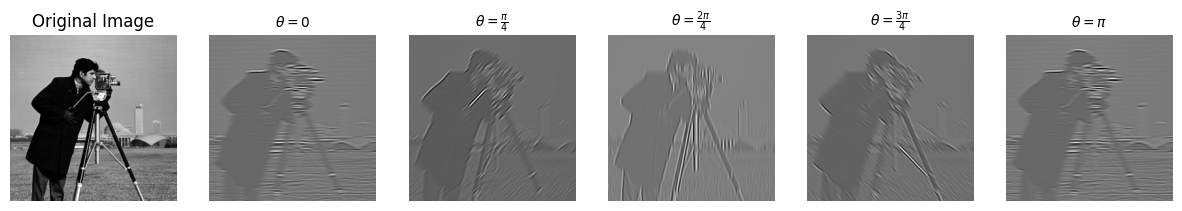

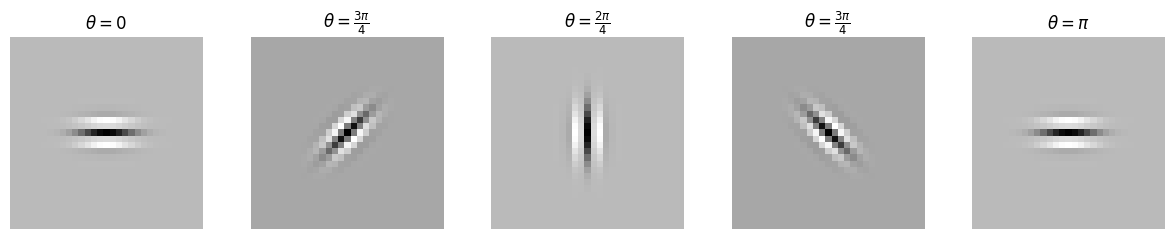

In [10]:
filter_two = GFilter(dir='./data/camera.tif',
                     filters=[
                         GaborFilter(31, 3.5, 0, 1.5, 0.5),
                         GaborFilter(31, 3.5, np.pi / 4, 1.5, 0.5),
                         GaborFilter(31, 3.5, (2 * np.pi) / 4, 1.5, 0.5),
                         GaborFilter(31, 3.5, (3 * np.pi) / 4, 1.5, 0.5),
                         GaborFilter(31, 3.5, (4 * np.pi) / 4, 1.5, 0.5)
                     ])

filter_two.exec()

#### $\lambda$

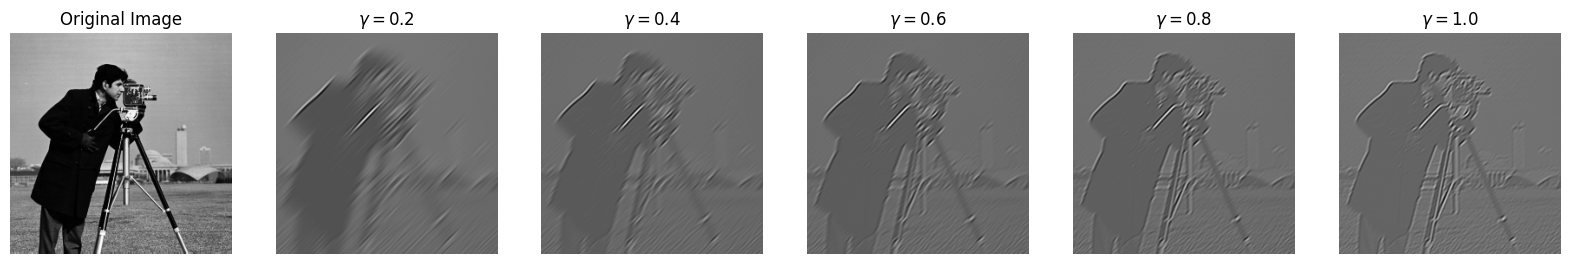

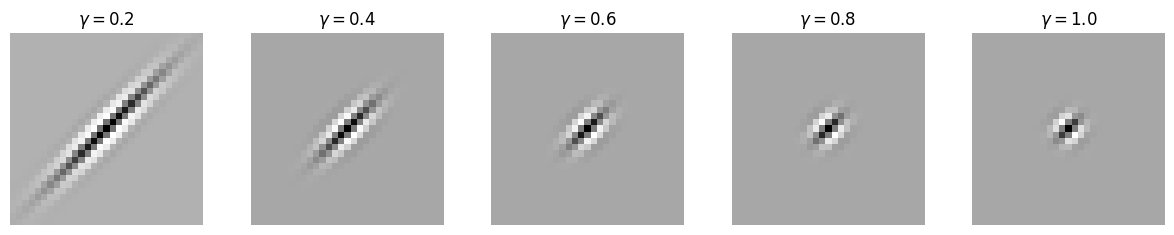

In [29]:
filter_two = GFilter(dir='./data/camera.tif',
                     filters=[
                         GaborFilter(31, 3.8, np.pi / 4, 1.5, 0.2),
                         GaborFilter(31, 3.5, np.pi / 4, 1.5, 0.4),
                         GaborFilter(31, 3.5, np.pi / 4, 1.5, 0.6),
                         GaborFilter(31, 3.5, np.pi / 4, 1.5, 0.8),
                         GaborFilter(31, 3.5, np.pi / 4, 1.5, 1.0)
                     ])

filter_two.exec()

#### $\gamma$

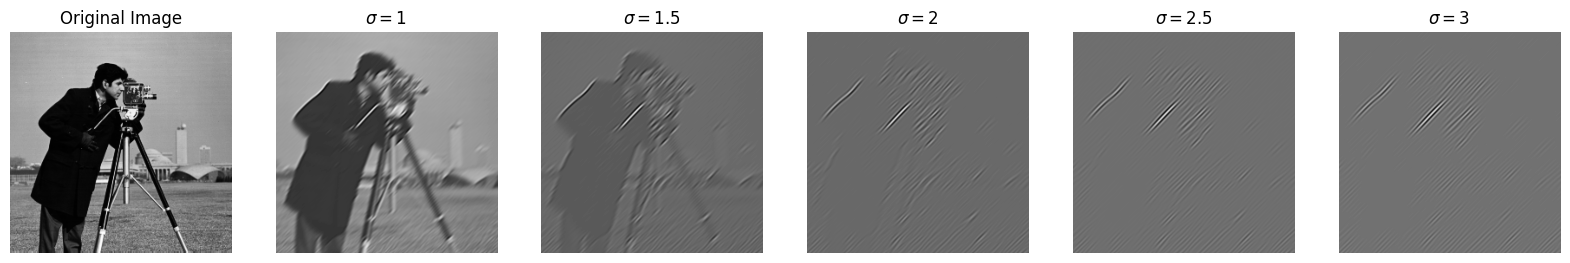

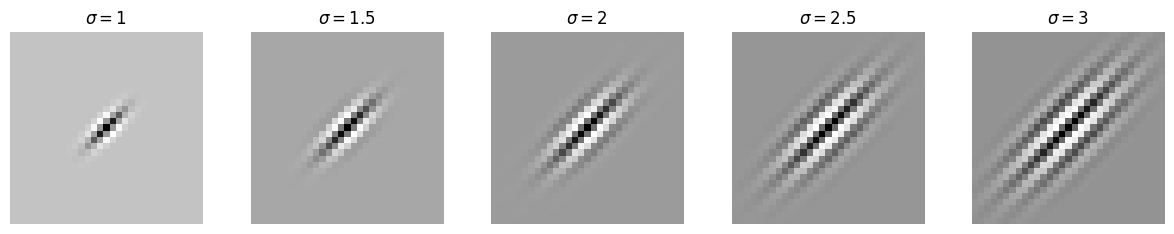

In [37]:
filter_two = GFilter(dir='./data/camera.tif',
                     filters=[
                         GaborFilter(31, 3.5, np.pi / 4, 1, 0.4),
                         GaborFilter(31, 3.5, np.pi / 4, 1.5, 0.4),
                         GaborFilter(31, 3.5, np.pi / 4, 2, 0.4),
                         GaborFilter(31, 3.5, np.pi / 4, 2.5, 0.4),
                         GaborFilter(31, 3.5, np.pi / 4, 3, 0.4)
                     ])

filter_two.exec()